# Train a diffusion model

In [2]:
# uncomment to install the necessary libraries in Colab
!pip install diffusers[training]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Training configuration

In [4]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

## Load the dataset

In [5]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

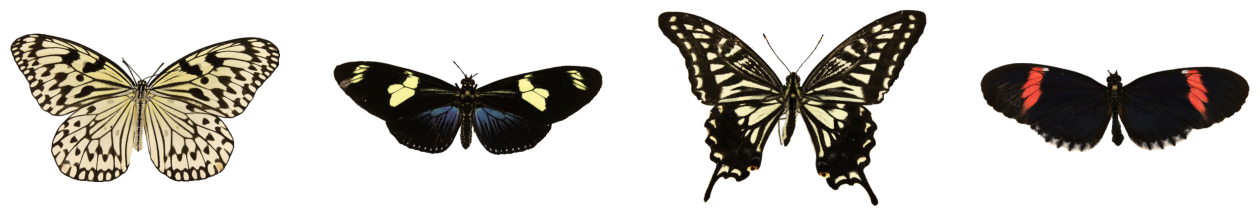

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [7]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [8]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [9]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Create a UNet2DModel

In [10]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [11]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [12]:
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


## Create a scheduler

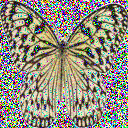

In [13]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [14]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

## Train the model

In [15]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [16]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [17]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

In [23]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/ddpm-butterflies-128 is already a clone of https://huggingface.co/PranavVispute/ddpm-butterflies-128. Make sure you pull the latest changes with `repo.git_pull()`.


Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Upload file samples/0009.png:   7%|6         | 32.0k/479k [00:00<?, ?B/s]

Upload file samples/0029.png:   7%|6         | 32.0k/468k [00:00<?, ?B/s]

Upload file samples/0019.png:   7%|6         | 32.0k/458k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1734031537.9d6ddd001831.645.2:  14%|#3        | 32.0k/234k …

To https://huggingface.co/PranavVispute/ddpm-butterflies-128
   ab82dea..402180c  main -> main

   ab82dea..402180c  main -> main



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

To https://huggingface.co/PranavVispute/ddpm-butterflies-128
   402180c..97a3f1c  main -> main

   402180c..97a3f1c  main -> main



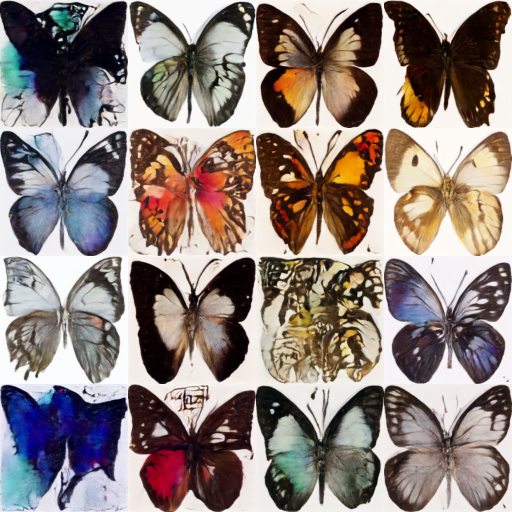

In [24]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])